In [1]:
from fastai import *
from fastai.vision import *
from pathlib import Path
import PIL
import cv2

from utils import FocalLoss, f1
from wrn4 import *

In [146]:
MASKS = 'train.csv'

PATH = Path('./')

TRAIN = Path('train/')

TRAIN64 = Path('train64/')
TRAIN128 = Path('train128/')
TRAIN256 = Path('train256/')
TRAIN512 = Path('train512/')
TEST256 = Path('test256/')

SAMPLE = Path('sample_submission.csv')

seg = pd.read_csv(PATH/MASKS)
sample_sub = pd.read_csv(PATH/SAMPLE)
train_names = list(seg.Id.values)
test_names = list(sample_sub.Id.values)

In [139]:
def open_image4d(path:PathOrStr)->Image:
    '''open RGBA image from 4 different 1-channel files.
    return: numpy array [4, sz, sz]'''
    flags = cv2.IMREAD_GRAYSCALE
    red = cv2.imread(str(path)+ '_red.png', flags)
    blue = cv2.imread(str(path)+ '_blue.png', flags)
    green = cv2.imread(str(path)+ '_green.png', flags)
    yellow = cv2.imread(str(path)+ '_yellow.png', flags)
    im = np.stack(([red, green, blue, yellow]))

    return Image(Tensor(im).div_(255))

def open_image4c(fn:PathOrStr)->Image:
    "Return `Image` object created from image in file `fn`."
    x = PIL.Image.open(fn)
    return Image(pil2tensor(x).float().div_(255))

In [140]:
%time im = open_image4d(TRAIN/fname)

CPU times: user 25.4 ms, sys: 9.49 ms, total: 34.8 ms
Wall time: 381 ms


In [141]:
im.shape

torch.Size([4, 512, 512])

In [142]:
%time x = open_image4c(TRAIN512/(fname+'.png'))

CPU times: user 17.7 ms, sys: 5.87 ms, total: 23.5 ms
Wall time: 32.8 ms


In [143]:
x.shape

torch.Size([4, 512, 512])

In [144]:
class Image4C_ds(ImageMultiDataset):
    def __init__(self, fns:FilePathList, labels:ImgLabels, classes:Optional[Collection[Any]]=None):
        super().__init__(fns, labels, classes)
    def __getitem__(self,i:int)->Tuple[Image, np.ndarray]: return open_image4d(self.x[i]), self.encode(self.y[i])
    def _get_x(self,i): return open_image4d(self.x[i])

In [147]:
from fastai.data_block import _df_to_fns_labels
fnames, labels = _df_to_fns_labels(seg, label_delim=' ', fn_col=0, label_col=1)
test_fnames, _ = _df_to_fns_labels(sample_sub, suffix='.png', fn_col=0, label_col=1)

In [148]:
classes = uniqueify(np.concatenate(labels))

In [149]:
stats = ([0.485, 0.456, 0.406, 0.406], [0.229, 0.224, 0.225, 0.225])
norm,denorm = normalize_funcs(*stats)

In [150]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [151]:
def get_data(sz=64, bs=64):
    folder=TRAIN
    test_ds=None
#     test_ds = Image4C_ds.from_single_folder(test_fnames, classes)
    train, val = Image4C_ds.from_folder(PATH, folder, fnames, labels, valid_pct=0.2, classes=classes)
    return ImageDataBunch.create(train_ds=train, valid_ds=val, test_ds=test_ds,
                                 ds_tfms=tfms, tfms=norm, bs=bs, size=sz)

# def get_data(sz=64, bs=64):
#     test_ds=None
#     if sz==64: folder=TRAIN64
#     if sz==128: folder=TRAIN128
#     if sz==256: 
#         folder=TRAIN256
#         test_ds = Image4C_ds.from_single_folder(test_fnames, classes)
        
#     train, val = Image4C_ds.from_folder(PATH, folder, fnames, labels, valid_pct=0.2, classes=classes)
#     return ImageDataBunch.create(train_ds=train, valid_ds=val, test_ds=test_ds,
#                                  ds_tfms=tfms, tfms=norm, bs=bs, size=sz)

In [152]:
train, val = Image4C_ds.from_folder(PATH, TRAIN, fnames, labels, valid_pct=0.2, classes=classes)

In [153]:
class_sample_count = array([12885,  1254,  3621,  1561,  1858,  2513,  1008,  2822,    53,
          45,    28,  1093,   688,   537,  1066,    21,   530,   210,
         902,  1482,   172,  3777,   802,  2965,   322,  8228,   328,
          11])
print(class_sample_count)

[12885  1254  3621  1561  1858  2513  1008  2822    53    45    28  1093   688   537  1066    21   530   210   902
  1482   172  3777   802  2965   322  8228   328    11]


In [156]:
from torch.utils.data.sampler import WeightedRandomSampler
wrs = WeightedRandomSampler(weight, len(weight))

In [177]:
data = get_data(24, 16)

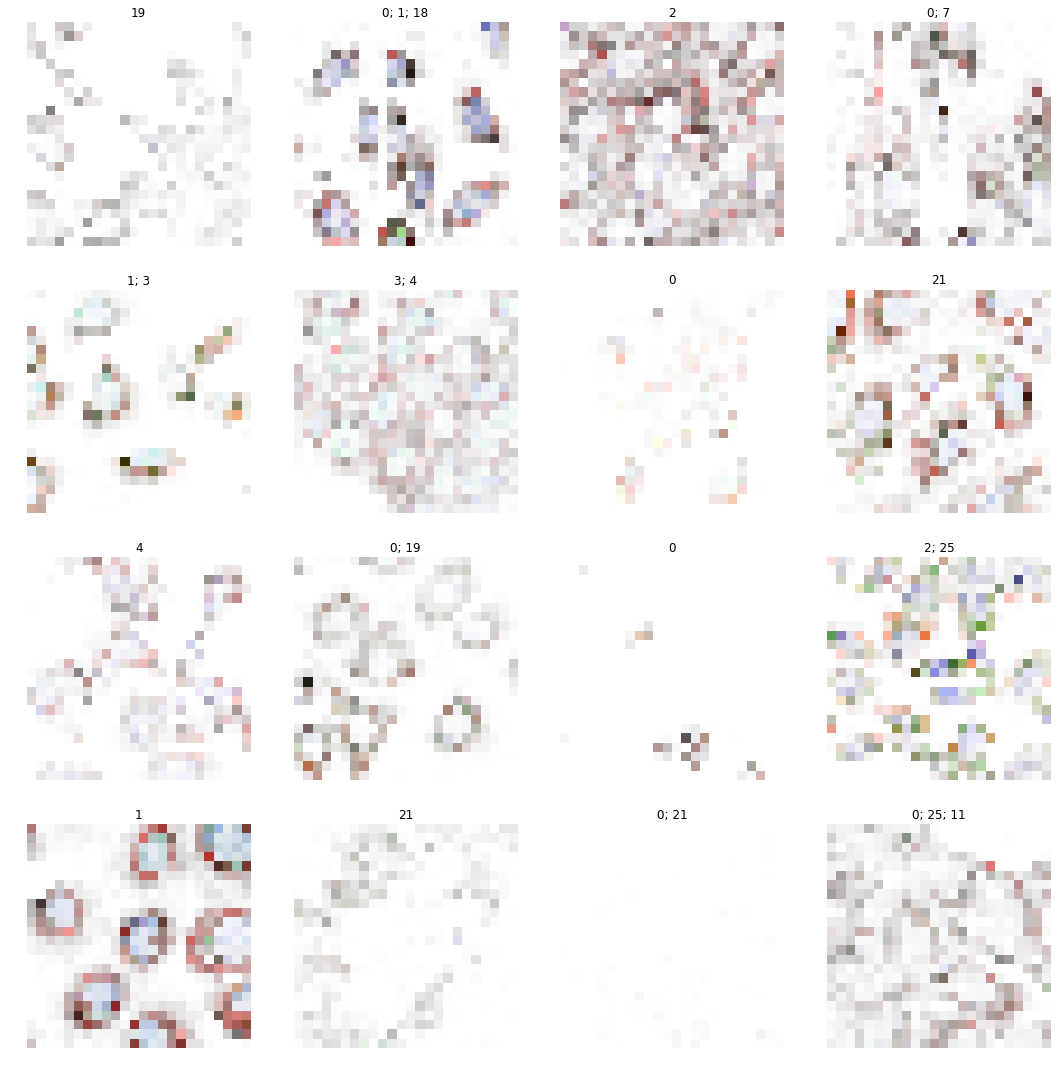

In [178]:
data.show_batch(rows=4, figsize=(15,15))

In [13]:
# seg = pd.read_csv(PATH/MASKS)
# data64 = (ImageFileList.from_folder(PATH)
#         .label_from_df(seg, sep=' ', folder=TRAIN64, suffix='.png')  
#         .random_split_by_pct(0.2)
#         .datasets(Image4C_ds)  
#         .transform(tfms)             
#         .databunch()
#         .normalize(imagenet_stats))

In [170]:
arch = wrn_small_4()

In [180]:
def get_learner(data, loss=None, fp16=False):
    learn = Learner(data, arch , metrics=[accuracy_thresh, f1])
    if loss: learn.loss_func=FocalLoss()
    if fp16: learn.to_fp16();
    return learn

In [183]:
learn = get_learner(data, True, False)

In [184]:
%time learn.fit_one_cycle(10, 1e-2/3)

epoch,train_loss,valid_loss,accuracy_thresh,f1


Traceback (most recent call last):
  File "/Users/thomascapelle/anaconda3/envs/fastai/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/thomascapelle/anaconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/thomascapelle/anaconda3/envs/fastai/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/thomascapelle/anaconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/thomascapelle/anaconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/thomascapelle/anaconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, bu

RuntimeError: Expected object of scalar type Float but got scalar type Half for argument #2 'weight'

In [29]:
learn.save('wrn4_128')

In [ ]:
%time learn.fit_one_cycle(10, 1e-2/3)

epoch,train_loss,valid_loss,accuracy_thresh,f1
